In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [8]:
# --- Config ---
IMAGE_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 20
DATA_DIR = "dataset"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# --- Dataset ---
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
        mask = np.expand_dims(mask, axis=0)  # CHW

        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).float()

        return image, mask

# --- UNet Model ---
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))

In [4]:
def train():
    dataset = SegmentationDataset(os.path.join(DATA_DIR, "images"), os.path.join(DATA_DIR, "masks"))
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = UNet().to(DEVICE)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            preds = model(images)
            loss = loss_fn(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {epoch_loss / len(loader):.4f}")

    torch.save(model.state_dict(), "unet_segmentation.pth")
    print("Model saved to unet_segmentation.pth")

In [9]:
train()

Epoch 1/20: 100%|██████████| 639/639 [08:58<00:00,  1.19it/s]


Epoch 1 Loss: 0.5658


Epoch 2/20: 100%|██████████| 639/639 [08:28<00:00,  1.26it/s]


Epoch 2 Loss: 0.4991


Epoch 3/20: 100%|██████████| 639/639 [08:28<00:00,  1.26it/s]


Epoch 3 Loss: 0.4779


Epoch 4/20: 100%|██████████| 639/639 [08:28<00:00,  1.26it/s]


Epoch 4 Loss: 0.4579


Epoch 5/20: 100%|██████████| 639/639 [08:29<00:00,  1.26it/s]


Epoch 5 Loss: 0.4472


Epoch 6/20: 100%|██████████| 639/639 [08:28<00:00,  1.26it/s]


Epoch 6 Loss: 0.4363


Epoch 7/20: 100%|██████████| 639/639 [08:28<00:00,  1.26it/s]


Epoch 7 Loss: 0.4313


Epoch 8/20: 100%|██████████| 639/639 [08:37<00:00,  1.23it/s]


Epoch 8 Loss: 0.4249


Epoch 9/20: 100%|██████████| 639/639 [08:32<00:00,  1.25it/s]


Epoch 9 Loss: 0.4196


Epoch 10/20: 100%|██████████| 639/639 [08:27<00:00,  1.26it/s]


Epoch 10 Loss: 0.4148


Epoch 11/20: 100%|██████████| 639/639 [08:29<00:00,  1.25it/s]


Epoch 11 Loss: 0.4099


Epoch 12/20: 100%|██████████| 639/639 [08:29<00:00,  1.26it/s]


Epoch 12 Loss: 0.4047


Epoch 13/20: 100%|██████████| 639/639 [08:28<00:00,  1.26it/s]


Epoch 13 Loss: 0.4013


Epoch 14/20: 100%|██████████| 639/639 [08:29<00:00,  1.25it/s]


Epoch 14 Loss: 0.3958


Epoch 15/20: 100%|██████████| 639/639 [08:31<00:00,  1.25it/s]


Epoch 15 Loss: 0.3894


Epoch 16/20: 100%|██████████| 639/639 [08:56<00:00,  1.19it/s]


Epoch 16 Loss: 0.3809


Epoch 17/20: 100%|██████████| 639/639 [08:55<00:00,  1.19it/s]


Epoch 17 Loss: 0.3750


Epoch 18/20: 100%|██████████| 639/639 [08:32<00:00,  1.25it/s]


Epoch 18 Loss: 0.3663


Epoch 19/20: 100%|██████████| 639/639 [08:33<00:00,  1.24it/s]


Epoch 19 Loss: 0.3555


Epoch 20/20: 100%|██████████| 639/639 [08:17<00:00,  1.28it/s]

Epoch 20 Loss: 0.3254
Model saved to unet_segmentation.pth


# run inference

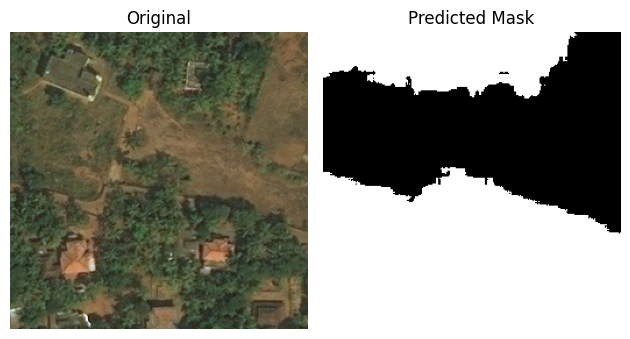

In [12]:
import cv2
import torch
import numpy as np
from model_train import UNet
import matplotlib.pyplot as plt

IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load image
image_path = "new_test.jpg"  # Change this to your test image path
image = cv2.imread(image_path)
orig = image.copy()
image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)

# Load model
model = UNet().to(DEVICE)
model.load_state_dict(torch.load("unet_segmentation.pth", map_location=DEVICE))
model.eval()

# Predict
with torch.no_grad():
    pred = model(image_tensor)
    pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255

# Resize to original size
pred_mask_resized = cv2.resize(pred_mask, (orig.shape[1], orig.shape[0]))
cv2.imwrite("inference_output.png", pred_mask_resized)

# Show result
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask_resized, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

Evaluating:   0%|          | 0/5108 [00:00<?, ?it/s]C:\Users\parth\AppData\Local\Temp\ipykernel_5812\1701774182.py:81: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_np = (np.array(image * 255)).astype(np.uint8)


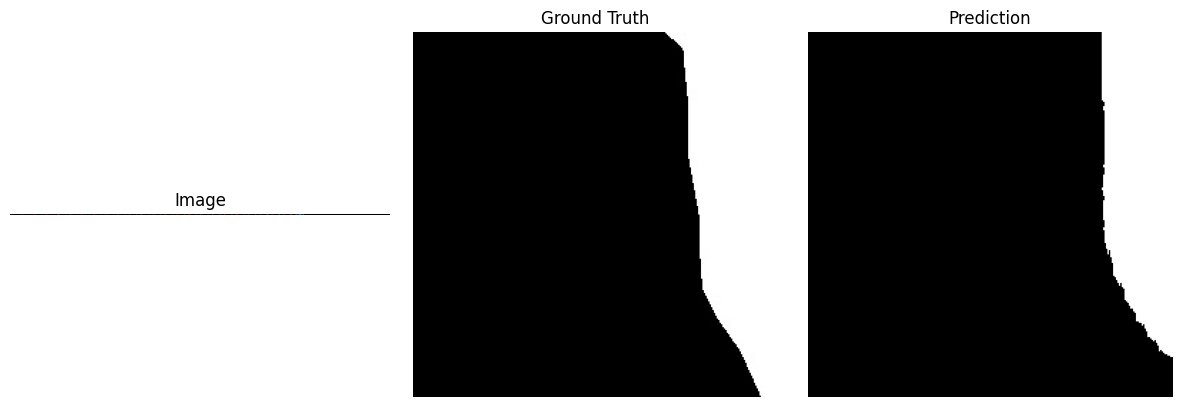

Evaluating:   0%|          | 1/5108 [00:00<33:37,  2.53it/s]

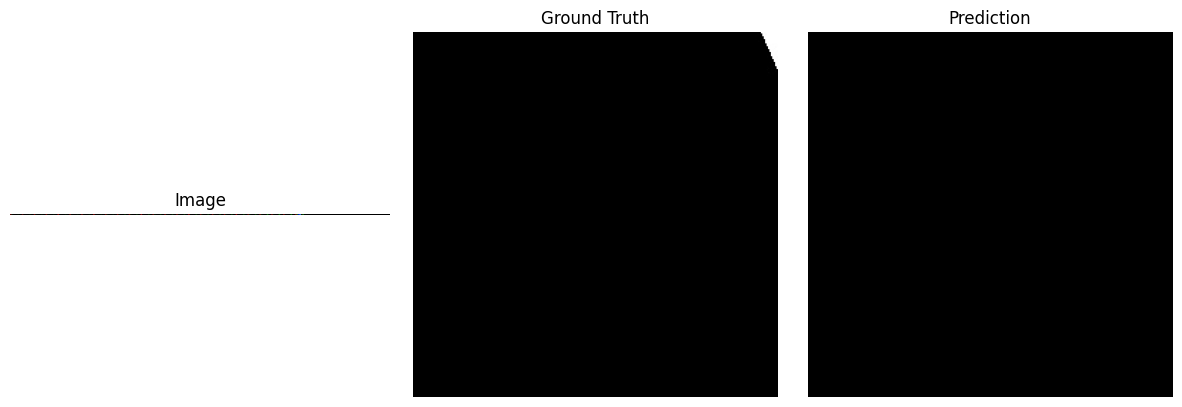

Evaluating:   0%|          | 2/5108 [00:00<36:44,  2.32it/s]

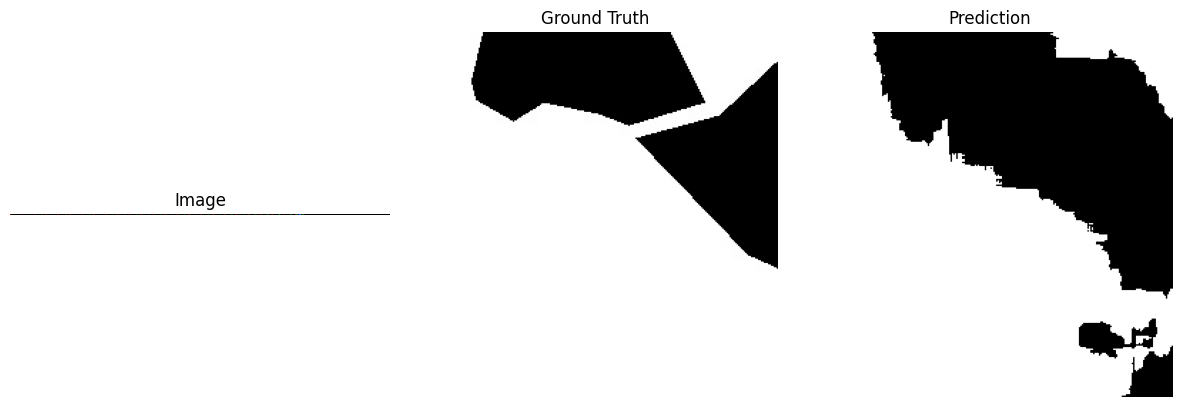

Evaluating:   0%|          | 3/5108 [00:01<31:31,  2.70it/s]

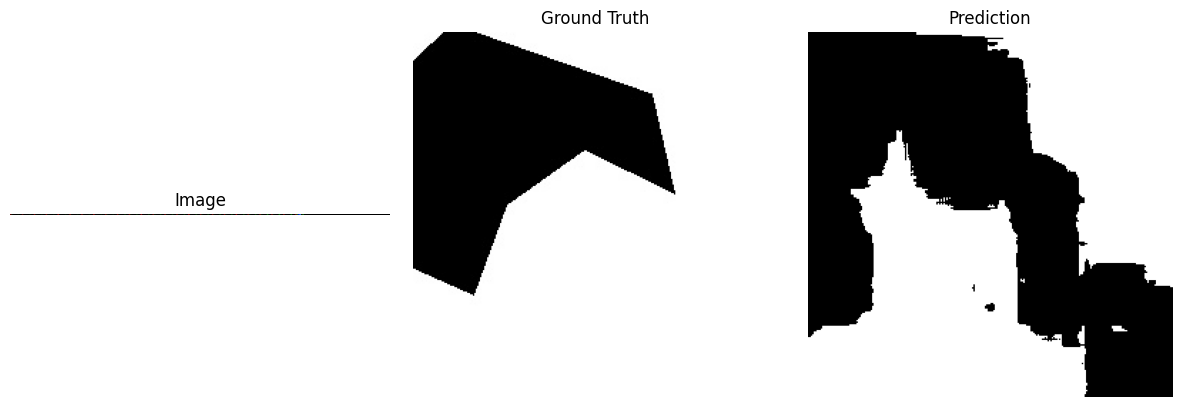

Evaluating:   0%|          | 4/5108 [00:01<29:48,  2.85it/s]

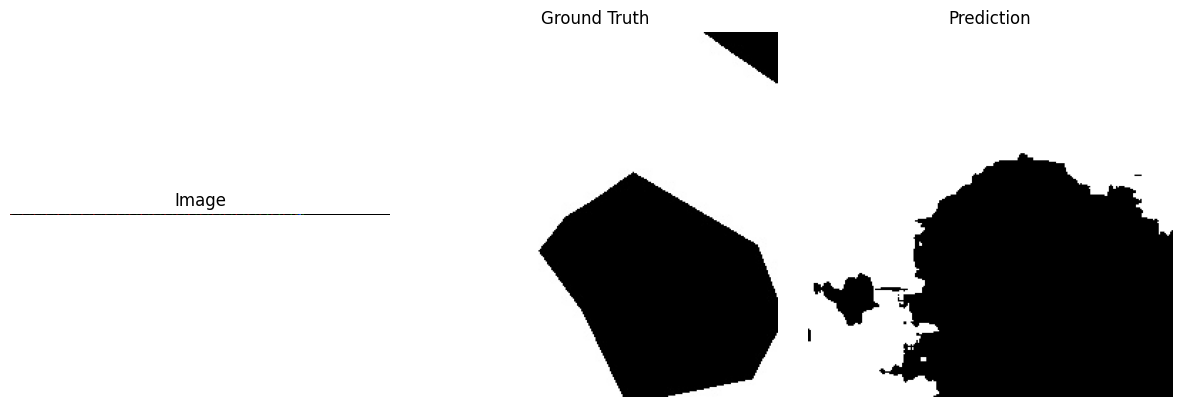

Evaluating:   0%|          | 5/5108 [00:01<30:28,  2.79it/s]

Average Dice Score: 0.6754
Average IoU Score:  0.5863


In [20]:

import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from model_train import UNet  # Assumes UNet is defined in model_train.py

IMAGE_SIZE = 256
BATCH_SIZE = 4
DATA_DIR = "dataset"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Dataset ---
class TestDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*.jpg")))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0

        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float()
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()

        return image_tensor, mask_tensor, image.copy(), mask.copy()  # return copies for clean visualization

# --- Metrics ---
def dice_score(pred, target):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred & target).float().sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def iou_score(pred, target):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred & target).float().sum()
    union = (pred | target).float().sum()
    return intersection / (union + 1e-8)

# --- Evaluation ---
def evaluate():
    dataset = TestDataset(os.path.join(DATA_DIR, "images"), os.path.join(DATA_DIR, "masks"))
    loader = DataLoader(dataset, batch_size=1, shuffle=False)  # batch size 1 for visualization

    # Load model
    model = UNet().to(DEVICE)
    model.load_state_dict(torch.load("unet_segmentation.pth", map_location=DEVICE))
    model.eval()

    total_dice = 0
    total_iou = 0
    count = 0

    with torch.no_grad():
        for image_tensor, mask_tensor, image, mask in tqdm(loader, desc="Evaluating"):
            if count == 5:  # Limit to first 5 images for visualization
                break
            image_tensor, mask_tensor = image_tensor.to(DEVICE), mask_tensor.to(DEVICE)
            pred = model(image_tensor)

            dice = dice_score(pred, mask_tensor).item()
            iou = iou_score(pred, mask_tensor).item()
            total_dice += dice
            total_iou += iou
            count += 1

            pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255
            image_np = (np.array(image * 255)).astype(np.uint8)

            # Convert HWC for matplotlib
            if image_np.shape[0] == 1 or image_np.ndim == 2:
                image_np = np.stack([image_np]*3, axis=-1)

            # Visualize 3 side-by-side
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Image")
            axes[1].imshow(mask.squeeze(), cmap="gray")
            axes[1].set_title("Ground Truth")
            axes[2].imshow(pred_mask, cmap="gray")
            axes[2].set_title("Prediction")
            for ax in axes:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

    print(f"Average Dice Score: {total_dice / count:.4f}")
    print(f"Average IoU Score:  {total_iou / count:.4f}")

if __name__ == "__main__":
    evaluate()